In [3]:
# import spacy
# from es_lemmatizer import lemmatize

import nltk
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import stanza
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import sklearn
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
import numpy as np
import scipy.sparse as sp
import pandas as pd
import json

from gensim.models import Word2Vec

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidanc

# 1 - Lematizando el Corpus

Los siguientes pasos se realizan una sola vez y se exporta el corpus lematizado a un archivo para evitar repetir la operación que es costosa en tiempo y recursos

In [2]:
# Bajamos el lemmatizador en español. Peso 226MB
stanza.download('es')
nltk.download('stopwords')

1.3.3


In [37]:
nlp = stanza.Pipeline('es', processors='tokenize,lemma')
noticias = open("clarin.txt", 'r')
texto = noticias.read()
doc = nlp(texto)

2021-09-22 00:08:44 WARNING: Language es package default expects mwt, which has been added
2021-09-22 00:08:44 INFO: Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| lemma     | ancora  |

2021-09-22 00:08:44 INFO: Use device: cpu
2021-09-22 00:08:44 INFO: Loading: tokenize
2021-09-22 00:08:44 INFO: Loading: mwt
2021-09-22 00:08:44 INFO: Loading: lemma
2021-09-22 00:08:44 INFO: Done loading processors!


In [64]:
# lemmatized = [[token.lemma.lower() for token in sentence if token.lemma.isalpha() and token.lemma not in stopwords.words("spanish")] for sentence in doc.sentences]
lemmatized = []
for sentence in doc.sentences:
    newsentence = []
    for token in sentence.words:
        if token.lemma.isalpha() and token.lemma not in stopwords.words("spanish"):
            newsentence.append(token.lemma.lower())
    lemmatized.append(newsentence)

Exportamos a un json así no es necesario volver a correr el pre-procesamiento que tarda un buen rato

In [191]:
with open("clarin-lemmatized.json", 'w') as f:
    try:
        json.dump(lemmatized, f)        
    except e:
        print(e)


# 2 - Vectorizamos el texto preprocesado

Traemos el JSON guardado previamente para trabajar con los datos ya lemmatizados

In [4]:
f = open("clarin-lemmatized.json", 'r')
lemmatized = json.load(f)

In [5]:
tokens_raw = [token for sentence in lemmatized for token in sentence]

2103830

Contamos cuantas veces aparece cada palabra

In [107]:
words = {}
for token in tokens_raw:
    if token in words:
        words[token] += 1
    else:
        words[token] = 1

{k: v for k, v in sorted(words.items(), key=lambda item: -item[1])}

{'ser': 64230,
 'haber': 24412,
 'tener': 18408,
 'hacer': 15681,
 'poder': 13028,
 'año': 12076,
 'decir': 9996,
 'ir': 8380,
 'día': 7321,
 'primero': 6953,
 'si': 6765,
 'dos': 6478,
 'dar': 6220,
 'vez': 5154,
 'ver': 5125,
 'recibir': 4900,
 'pasar': 4821,
 'clarín': 4640,
 'país': 4567,
 'llegar': 4510,
 'después': 4376,
 'gobierno': 4370,
 'nuevo': 4343,
 'hoy': 4329,
 'alguno': 4239,
 'presidente': 4167,
 'quedar': 4093,
 'saber': 4073,
 'último': 4032,
 'argentina': 4009,
 'fernández': 3986,
 'querer': 3891,
 'parte': 3767,
 'mismo': 3707,
 'lunes': 3498,
 'según': 3493,
 'deber': 3491,
 'persona': 3488,
 'tiempo': 3458,
 'seguir': 3413,
 'ahora': 3379,
 'viernes': 3341,
 'frente': 3331,
 'elección': 3246,
 'casa': 3241,
 'además': 3226,
 'ciudad': 3223,
 'llevar': 3217,
 'foto': 3213,
 'semana': 3202,
 'momento': 3155,
 'tres': 3124,
 'nacional': 3121,
 'dejar': 3097,
 'mujer': 3044,
 'caso': 3039,
 'hablar': 3025,
 'luego': 3008,
 'cada': 3002,
 'macri': 2976,
 'bien': 2962,

# Primer Enfoque: CountVectorizer

In [76]:
tf_vectorizer = CountVectorizer(max_df=0.05, min_df=5)
tf = tf_vectorizer.fit_transform([" ".join(sentence) for sentence in lemmatized if len(sentence) > 10])

In [77]:
# Tasponemos para que queden filas que representan para cada palabra, en qué oraciones aparecen
np.transpose(tf).shape

(19561, 84332)

Proyectamos a dos dimensiones usando SVD

In [88]:
word_count_vector = np.transpose(tf)
print(word_count_vector.shape)
svd = TruncatedSVD(n_components=2, n_iter=5)
principalComponents = svd.fit_transform(word_count_vector)
principalComponents.shape

(19561, 84332)


(19561, 2)

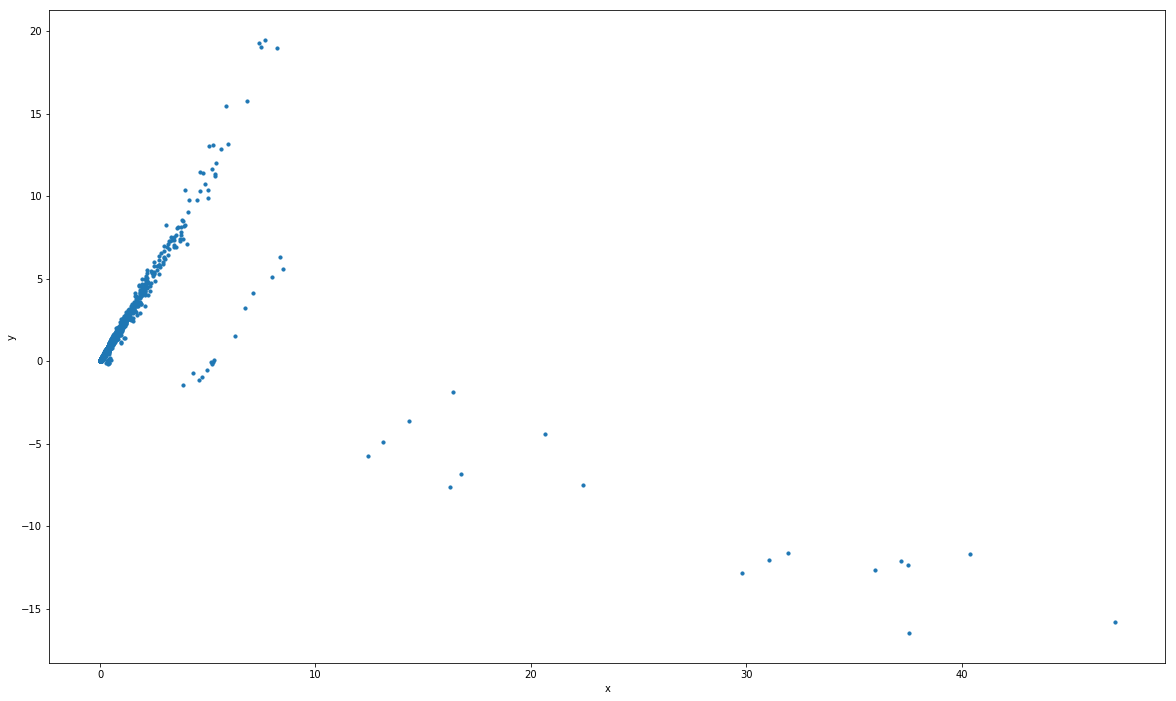

In [89]:
points = pd.DataFrame([(coord[0], coord[1]) for coord in principalComponents], columns=["x", "y"])

points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [90]:
km_model = KMeans(n_clusters=50)
km_model.fit(word_count_vectors)
print("Done")

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float


Done


In [84]:
c = Counter(sorted(km_model.labels_))

In [85]:
print("\nTotal clusters:",len(c))
for cluster in c:
    print ("Cluster#",cluster," - Total words:",c[cluster])


Total clusters: 50
Cluster# 0  - Total words: 1
Cluster# 1  - Total words: 1
Cluster# 2  - Total words: 1
Cluster# 3  - Total words: 3
Cluster# 4  - Total words: 6
Cluster# 5  - Total words: 1
Cluster# 6  - Total words: 119
Cluster# 7  - Total words: 2
Cluster# 8  - Total words: 1
Cluster# 9  - Total words: 1
Cluster# 10  - Total words: 1
Cluster# 11  - Total words: 1
Cluster# 12  - Total words: 1
Cluster# 13  - Total words: 1
Cluster# 14  - Total words: 1
Cluster# 15  - Total words: 1
Cluster# 16  - Total words: 1
Cluster# 17  - Total words: 4
Cluster# 18  - Total words: 1
Cluster# 19  - Total words: 1
Cluster# 20  - Total words: 1
Cluster# 21  - Total words: 7811
Cluster# 22  - Total words: 1
Cluster# 23  - Total words: 1
Cluster# 24  - Total words: 1
Cluster# 25  - Total words: 1
Cluster# 26  - Total words: 1
Cluster# 27  - Total words: 1
Cluster# 28  - Total words: 1
Cluster# 29  - Total words: 1
Cluster# 30  - Total words: 1
Cluster# 31  - Total words: 1
Cluster# 32  - Total word

La separación en clusters no es buena.
Pocos clusters concentran la mayoría de las palabras, los datos están concentrados y los clusters no separan segun un criterio significativo que permita armar clases de equivalencia

## Segundo Enfoque: Matriz de Coocurrencia

Nos quedamos con las palabras que aparezcan tres veces o más

In [125]:
words_filtered = {k: v for k, v in sorted(words.items(), key=lambda item: -item[1]) if v > 20}
len(words_filtered)

9107

Creamos una matriz de coocurrencia vacía

In [126]:
coocurrence_matrix = pd.DataFrame([[0] * len(words_filtered)] * len(words_filtered))

Creamos un diccionario donde para cada palabra diga su posición en la matriz de coocurrencia

In [127]:
word2id = {}
for i, k in enumerate(words_filtered):
    word2id[k] = i

Generamos la matriz de coocurrencia

In [128]:
window_size = 3
for sentence in lemmatized:
    for pos, word in enumerate(sentence):
        start = max(0, pos - windows_size)
        end = min(len(sentence), pos + window_size)
        for j in range(start, end):
            if j != pos and word in word2id and sentence[j] in word2id:
                coocurrence_matrix[word2id[word]][word2id[sentence[j]]] += 1

In [129]:
coocurrence_matrix

0     1     2     3     4     5     6     7     8     9     ...  9097  \
0     4554  3521  2109  1800  2339  1486  2107  1083   741  1516  ...     2   
1     3406  1100   930  1207   913   707   894   535   260   270  ...     2   
2     1997   957   690   728   661   929   528   544   208   230  ...     1   
3     1739  1153   720   643   781  1451   403   426   382   220  ...     0   
4     2168   882   631   802   190   250   465   300   154   146  ...     0   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
9102     3     1     1     1     0     0     1     0     0     0  ...     0   
9103     1     0     0     1     0     0     1     0     0     0  ...     0   
9104     1     2     0     1     0     0     0     0     0     0  ...     0   
9105     0     1     0     0     0     0     0     0     0     2  ...     0   
9106     0     1     0     0     0     0     0     0     0     0  ...     0   

      9098  9099  9100  9101  9102  9103  9104  9105  9106  
0        3     3     2    12     5     1     1     0     0  
1        0     0     0     0     1     0     3     0     0  
2        0     1     2     0     0     0     0     0     0  
3        0     1     0     0     1     1     2     0     0  
4        0     0     0     0     0     0     0     0     0  
...    ...   ...   ...   ...   ...   ...   ...   ...   ...  
9102     0     0     0     0     0     0     0     0     0  
9103     0     0     0     0     0     0     0     0     0  
9104     0     0     0     0     0     0     1     0     0  
9105     0     0     0     0     0     0     0     0     0  
9106     0     0     0     0     0     0     0     0     0  

[9107 rows x 9107 columns]

Reducimos la dimensión para poder graficar

In [130]:
svd = TruncatedSVD(n_components=2, n_iter=5)
principalComponentsCoOc = svd.fit_transform(coocurrence_matrix)
principalComponentsCoOc.shape

(9107, 2)

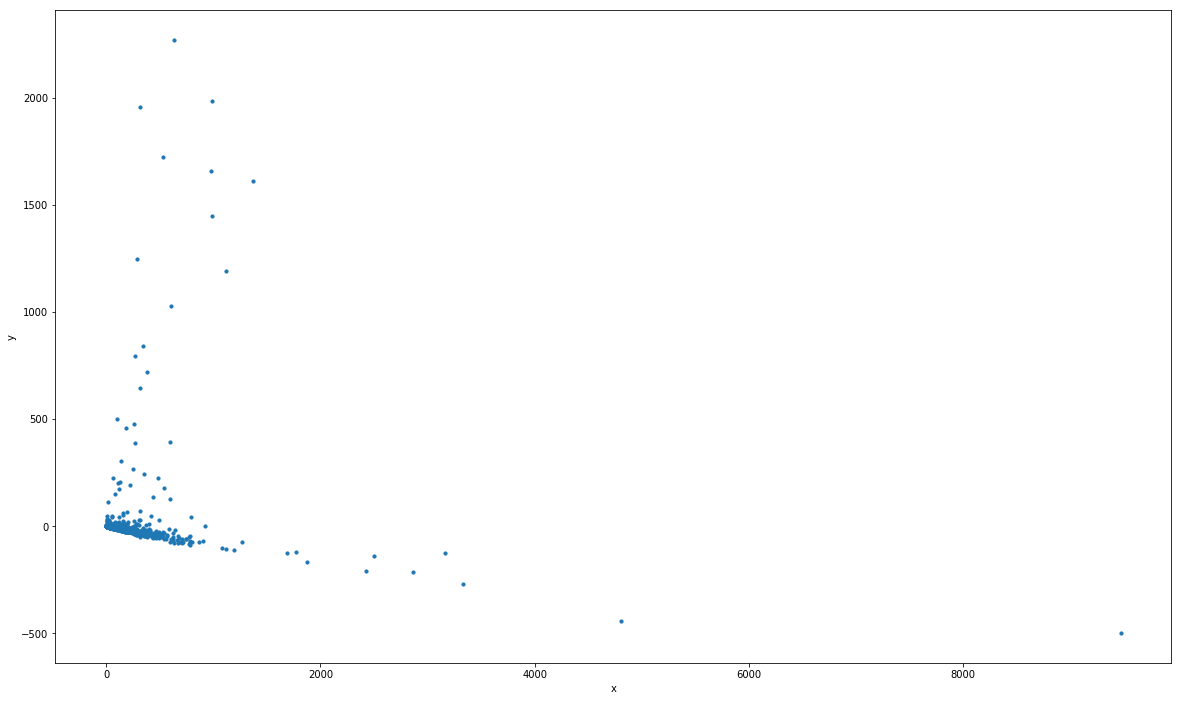

In [131]:
points = pd.DataFrame([(coord[0], coord[1]) for coord in principalComponentsCoOc], columns=["x", "y"])

points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [132]:
km_model = KMeans(n_clusters=50)
km_model.fit(coocurrence_matrix)
print("Done")

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:444: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://num

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:444: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://num

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:444: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  max_iter=max_iter, verbose=verbose)
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and gu

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

Done


In [134]:
c = Counter(sorted(km_model.labels_))
print("\nTotal clusters:",len(c))
for cluster in c:
    print ("Cluster#",cluster," - Total words:",c[cluster])


Total clusters: 50
Cluster# 0  - Total words: 1153
Cluster# 1  - Total words: 1
Cluster# 2  - Total words: 1
Cluster# 3  - Total words: 5
Cluster# 4  - Total words: 1
Cluster# 5  - Total words: 1
Cluster# 6  - Total words: 1
Cluster# 7  - Total words: 29
Cluster# 8  - Total words: 2
Cluster# 9  - Total words: 7345
Cluster# 10  - Total words: 1
Cluster# 11  - Total words: 1
Cluster# 12  - Total words: 1
Cluster# 13  - Total words: 1
Cluster# 14  - Total words: 1
Cluster# 15  - Total words: 351
Cluster# 16  - Total words: 1
Cluster# 17  - Total words: 1
Cluster# 18  - Total words: 1
Cluster# 19  - Total words: 1
Cluster# 20  - Total words: 1
Cluster# 21  - Total words: 1
Cluster# 22  - Total words: 118
Cluster# 23  - Total words: 1
Cluster# 24  - Total words: 1
Cluster# 25  - Total words: 1
Cluster# 26  - Total words: 1
Cluster# 27  - Total words: 52
Cluster# 28  - Total words: 3
Cluster# 29  - Total words: 1
Cluster# 30  - Total words: 1
Cluster# 31  - Total words: 1
Cluster# 32  - Tot

In [138]:
# Imprimir palabras asociadas a un cluster
num_cluster = 27

for i, word in enumerate(words_filtered):
    if km_model.labels_[i] == num_cluster:
        print(word)

quedar
según
frente
casa
además
ciudad
llevar
tres
dejar
hablar
luego
cada
pedir
partido
medio
volver
hora
encontrar
argentino
mes
mundo
punto
tras
vida
cambio
candidato
cuenta
pasado
equipo
menos
ganar
salir
segundo
historia
solo
vivir
paso
gente
mayor
trabajar
trabajo
varios
venir
asegurar
hombre
casi
hijo
cuatro
sólo
fin
detener
problema


La dispersion de los datos mejora un poco y las palabras están un poco más divididas entre varios clusters, pero aún no es suficiente para poder encontrar clases de equivalencia según los clusters

# Tercer enfoque: Word2Vec

Entrenamos un modelo Word2Vec desde cero usando únicamente las palabras de nuestro dataset

In [6]:
word2vec = Word2Vec(lemmatized, min_count=2)

Observamos el vocabulario de nuestro modelo

In [10]:
vocabulary = word2vec.wv.vocab
for k in vocabulary:
    print(k)
    print(vocabulary[k])

instalacion
Vocab(count:2, index:35165, sample_int:4294967296)
reparacion
Vocab(count:2, index:35166, sample_int:4294967296)
aire
Vocab(count:526, index:696, sample_int:4294967296)
acondicionado
Vocab(count:40, index:5794, sample_int:4294967296)
capital
Vocab(count:1018, index:308, sample_int:4294967296)
opinión
Vocab(count:298, index:1281, sample_int:4294967296)
info
Vocab(count:11, index:13479, sample_int:4294967296)
roberto
Vocab(count:537, index:681, sample_int:4294967296)
lavagna
Vocab(count:359, index:1055, sample_int:4294967296)
juan
Vocab(count:1844, index:140, sample_int:4294967296)
manuel
Vocab(count:431, index:877, sample_int:4294967296)
urtubey
Vocab(count:80, index:3604, sample_int:4294967296)
concentrar
Vocab(count:174, index:1986, sample_int:4294967296)
tres
Vocab(count:3124, index:51, sample_int:4294967296)
provincia
Vocab(count:1744, index:154, sample_int:4294967296)
mes
Vocab(count:2755, index:74, sample_int:4294967296)
elección
Vocab(count:3246, index:43, sample_int:

instrucción
Vocab(count:172, index:2002, sample_int:4294967296)
ufi
Vocab(count:85, index:3436, sample_int:4294967296)
descentralizad
Vocab(count:19, index:9409, sample_int:4294967296)
aprehensión
Vocab(count:18, index:9740, sample_int:4294967296)
investigador
Vocab(count:455, index:819, sample_int:4294967296)
sospechar
Vocab(count:60, index:4404, sample_int:4294967296)
aprovechar
Vocab(count:383, index:997, sample_int:4294967296)
simulaban
Vocab(count:4, index:24690, sample_int:4294967296)
télam
Vocab(count:235, index:1579, sample_int:4294967296)
florencia
Vocab(count:283, index:1347, sample_int:4294967296)
kirchner
Vocab(count:1071, index:289, sample_int:4294967296)
sorpresivo
Vocab(count:57, index:4551, sample_int:4294967296)
cristina
Vocab(count:1295, index:221, sample_int:4294967296)
cuba
Vocab(count:168, index:2049, sample_int:4294967296)
habana
Vocab(count:47, index:5252, sample_int:4294967296)
presidenta
Vocab(count:301, index:1270, sample_int:4294967296)
salud
Vocab(count:946,

cinta
Vocab(count:119, index:2676, sample_int:4294967296)
pájaro
Vocab(count:58, index:4497, sample_int:4294967296)
combinar
Vocab(count:112, index:2798, sample_int:4294967296)
personaje
Vocab(count:630, index:574, sample_int:4294967296)
popular
Vocab(count:541, index:674, sample_int:4294967296)
amenities
Vocab(count:3, index:28874, sample_int:4294967296)
unicornios
Vocab(count:2, index:35279, sample_int:4294967296)
vidrio
Vocab(count:101, index:3039, sample_int:4294967296)
cristal
Vocab(count:68, index:4057, sample_int:4294967296)
terciopelo
Vocab(count:4, index:24728, sample_int:4294967296)
satén
Vocab(count:2, index:35280, sample_int:4294967296)
casualidad
Vocab(count:57, index:4557, sample_int:4294967296)
símbolo
Vocab(count:147, index:2273, sample_int:4294967296)
valor
Vocab(count:798, index:434, sample_int:4294967296)
oro
Vocab(count:271, index:1405, sample_int:4294967296)
gloria
Vocab(count:73, index:3887, sample_int:4294967296)
eva
Vocab(count:81, index:3575, sample_int:4294967

prioritaria
Vocab(count:5, index:21958, sample_int:4294967296)
miremo
Vocab(count:5, index:21959, sample_int:4294967296)
viabilidad
Vocab(count:15, index:11062, sample_int:4294967296)
atajo
Vocab(count:15, index:11063, sample_int:4294967296)
agronegocio
Vocab(count:2, index:35415, sample_int:4294967296)
corran
Vocab(count:6, index:19644, sample_int:4294967296)
arco
Vocab(count:180, index:1940, sample_int:4294967296)
chubut
Vocab(count:115, index:2739, sample_int:4294967296)
eólico
Vocab(count:13, index:12133, sample_int:4294967296)
renovable
Vocab(count:22, index:8626, sample_int:4294967296)
complicar
Vocab(count:94, index:3199, sample_int:4294967296)
madryn
Vocab(count:26, index:7739, sample_int:4294967296)
genneia
Vocab(count:3, index:28967, sample_int:4294967296)
cammesa
Vocab(count:2, index:35416, sample_int:4294967296)
aerogenerador
Vocab(count:3, index:28968, sample_int:4294967296)
abastecer
Vocab(count:20, index:9165, sample_int:4294967296)
bromear
Vocab(count:50, index:5037, sa

feldman
Vocab(count:8, index:16590, sample_int:4294967296)
transcurso
Vocab(count:41, index:5733, sample_int:4294967296)
tuerca
Vocab(count:11, index:13592, sample_int:4294967296)
logrado
Vocab(count:15, index:11097, sample_int:4294967296)
parisino
Vocab(count:19, index:9464, sample_int:4294967296)
recompone
Vocab(count:3, index:29078, sample_int:4294967296)
abstracto
Vocab(count:15, index:11098, sample_int:4294967296)
lámina
Vocab(count:12, index:12817, sample_int:4294967296)
anotación
Vocab(count:36, index:6244, sample_int:4294967296)
señalamientos
Vocab(count:8, index:16591, sample_int:4294967296)
libretar
Vocab(count:27, index:7569, sample_int:4294967296)
demencial
Vocab(count:2, index:35527, sample_int:4294967296)
latente
Vocab(count:20, index:9183, sample_int:4294967296)
eventualmente
Vocab(count:53, index:4824, sample_int:4294967296)
desata
Vocab(count:12, index:12818, sample_int:4294967296)
desopilantes
Vocab(count:3, index:29079, sample_int:4294967296)
ingeniosa
Vocab(count:5,

esgrima
Vocab(count:27, index:7589, sample_int:4294967296)
kempes
Vocab(count:25, index:7966, sample_int:4294967296)
cuidad
Vocab(count:3, index:29203, sample_int:4294967296)
aguilera
Vocab(count:15, index:11142, sample_int:4294967296)
fifa
Vocab(count:109, index:2860, sample_int:4294967296)
centrocampista
Vocab(count:4, index:24988, sample_int:4294967296)
megan
Vocab(count:5, index:22104, sample_int:4294967296)
jugadora
Vocab(count:60, index:4434, sample_int:4294967296)
barra
Vocab(count:62, index:4329, sample_int:4294967296)
plate
Vocab(count:52, index:4906, sample_int:4294967296)
garantía
Vocab(count:115, index:2745, sample_int:4294967296)
desconozco
Vocab(count:6, index:19772, sample_int:4294967296)
legalidad
Vocab(count:23, index:8409, sample_int:4294967296)
aprevide
Vocab(count:4, index:24989, sample_int:4294967296)
hurtado
Vocab(count:31, index:6927, sample_int:4294967296)
definía
Vocab(count:8, index:16642, sample_int:4294967296)
nepo
Vocab(count:3, index:29204, sample_int:4294

marte
Vocab(count:53, index:4841, sample_int:4294967296)
júpiter
Vocab(count:33, index:6641, sample_int:4294967296)
saturno
Vocab(count:25, index:7981, sample_int:4294967296)
urano
Vocab(count:10, index:14553, sample_int:4294967296)
neptuno
Vocab(count:14, index:11678, sample_int:4294967296)
plutón
Vocab(count:36, index:6271, sample_int:4294967296)
telón
Vocab(count:18, index:9885, sample_int:4294967296)
aprendizaje
Vocab(count:77, index:3736, sample_int:4294967296)
lección
Vocab(count:42, index:5670, sample_int:4294967296)
zodiacal
Vocab(count:5, index:22186, sample_int:4294967296)
influenciado
Vocab(count:7, index:18151, sample_int:4294967296)
capricornio
Vocab(count:33, index:6642, sample_int:4294967296)
transitando
Vocab(count:27, index:7604, sample_int:4294967296)
decanato
Vocab(count:3, index:29326, sample_int:4294967296)
retrogradación
Vocab(count:9, index:15601, sample_int:4294967296)
emerger
Vocab(count:10, index:14554, sample_int:4294967296)
brotar
Vocab(count:4, index:25095,

Vocab(count:20, index:9258, sample_int:4294967296)
acuciante
Vocab(count:2, index:36045, sample_int:4294967296)
desvelado
Vocab(count:2, index:36046, sample_int:4294967296)
remil
Vocab(count:4, index:25207, sample_int:4294967296)
ficticia
Vocab(count:8, index:16771, sample_int:4294967296)
lluvioso
Vocab(count:16, index:10725, sample_int:4294967296)
lejano
Vocab(count:50, index:5071, sample_int:4294967296)
premiación
Vocab(count:9, index:15661, sample_int:4294967296)
volpi
Vocab(count:7, index:18238, sample_int:4294967296)
heker
Vocab(count:10, index:14616, sample_int:4294967296)
ardua
Vocab(count:5, index:22280, sample_int:4294967296)
divierto
Vocab(count:3, index:29468, sample_int:4294967296)
carpintería
Vocab(count:13, index:12264, sample_int:4294967296)
elegí
Vocab(count:40, index:5865, sample_int:4294967296)
narrador
Vocab(count:14, index:11715, sample_int:4294967296)
pensá
Vocab(count:15, index:11202, sample_int:4294967296)
persistencia
Vocab(count:9, index:15662, sample_int:42949

Vocab(count:2, index:36272, sample_int:4294967296)
kylian
Vocab(count:5, index:22400, sample_int:4294967296)
sarabia
Vocab(count:3, index:29618, sample_int:4294967296)
jr
Vocab(count:46, index:5375, sample_int:4294967296)
saint
Vocab(count:31, index:6962, sample_int:4294967296)
germain
Vocab(count:11, index:13789, sample_int:4294967296)
álrdeo
Vocab(count:5, index:22401, sample_int:4294967296)
tuchel
Vocab(count:9, index:15713, sample_int:4294967296)
príncipes
Vocab(count:8, index:16848, sample_int:4294967296)
reims
Vocab(count:2, index:36273, sample_int:4294967296)
keylor
Vocab(count:3, index:29619, sample_int:4294967296)
navas
Vocab(count:5, index:22402, sample_int:4294967296)
thiago
Vocab(count:29, index:7297, sample_int:4294967296)
abdou
Vocab(count:3, index:29620, sample_int:4294967296)
diallo
Vocab(count:2, index:36274, sample_int:4294967296)
kurzawa
Vocab(count:2, index:36275, sample_int:4294967296)
idrissa
Vocab(count:3, index:29621, sample_int:4294967296)
gueye
Vocab(count:3, 

alfonsín
Vocab(count:152, index:2214, sample_int:4294967296)
lotería
Vocab(count:15, index:11268, sample_int:4294967296)
mordaza
Vocab(count:2, index:36502, sample_int:4294967296)
bozal
Vocab(count:6, index:20139, sample_int:4294967296)
terragno
Vocab(count:12, index:13025, sample_int:4294967296)
desmesura
Vocab(count:6, index:20140, sample_int:4294967296)
cotejo
Vocab(count:28, index:7473, sample_int:4294967296)
utopía
Vocab(count:15, index:11269, sample_int:4294967296)
concebimos
Vocab(count:2, index:36503, sample_int:4294967296)
prolongación
Vocab(count:14, index:11778, sample_int:4294967296)
socialmente
Vocab(count:15, index:11270, sample_int:4294967296)
recicla
Vocab(count:2, index:36504, sample_int:4294967296)
asonada
Vocab(count:3, index:29788, sample_int:4294967296)
duraría
Vocab(count:7, index:18394, sample_int:4294967296)
eligiendo
Vocab(count:13, index:12352, sample_int:4294967296)
provee
Vocab(count:11, index:13842, sample_int:4294967296)
agrodólar
Vocab(count:2, index:3650

Vocab(count:5, index:22652, sample_int:4294967296)
ibérico
Vocab(count:13, index:12392, sample_int:4294967296)
doctrina
Vocab(count:46, index:5379, sample_int:4294967296)
bruces
Vocab(count:2, index:36836, sample_int:4294967296)
pregona
Vocab(count:9, index:15843, sample_int:4294967296)
pryce
Vocab(count:3, index:29981, sample_int:4294967296)
allison
Vocab(count:17, index:10408, sample_int:4294967296)
zyon
Vocab(count:2, index:36837, sample_int:4294967296)
campeona
Vocab(count:42, index:5690, sample_int:4294967296)
ta
Vocab(count:4, index:25630, sample_int:4294967296)
lou
Vocab(count:7, index:18485, sample_int:4294967296)
hectómetro
Vocab(count:2, index:36838, sample_int:4294967296)
mundiales
Vocab(count:38, index:6079, sample_int:4294967296)
allyson
Vocab(count:2, index:36839, sample_int:4294967296)
atleta
Vocab(count:114, index:2768, sample_int:4294967296)
decimoséptima
Vocab(count:3, index:29982, sample_int:4294967296)
wilbert
Vocab(count:2, index:36840, sample_int:4294967296)
court

insistirán
Vocab(count:3, index:30269, sample_int:4294967296)
picadura
Vocab(count:6, index:20364, sample_int:4294967296)
negligente
Vocab(count:7, index:18601, sample_int:4294967296)
antirreglamentaria
Vocab(count:4, index:25851, sample_int:4294967296)
culposa
Vocab(count:12, index:13142, sample_int:4294967296)
manager
Vocab(count:39, index:5986, sample_int:4294967296)
abosaleh
Vocab(count:2, index:37148, sample_int:4294967296)
carabajal
Vocab(count:19, index:9636, sample_int:4294967296)
corista
Vocab(count:3, index:30270, sample_int:4294967296)
candias
Vocab(count:2, index:37149, sample_int:4294967296)
contabiliza
Vocab(count:7, index:18602, sample_int:4294967296)
cuestionaron
Vocab(count:22, index:8766, sample_int:4294967296)
transitaba
Vocab(count:9, index:15925, sample_int:4294967296)
kirchneralberto
Vocab(count:2, index:37150, sample_int:4294967296)
arslanián
Vocab(count:6, index:20365, sample_int:4294967296)
claustro
Vocab(count:3, index:30271, sample_int:4294967296)
prodigio
Vo

balaenoptera
Vocab(count:4, index:25942, sample_int:4294967296)
acutorostrata
Vocab(count:2, index:37377, sample_int:4294967296)
bonaerensis
Vocab(count:2, index:37378, sample_int:4294967296)
aleta
Vocab(count:4, index:25943, sample_int:4294967296)
pectoral
Vocab(count:3, index:30420, sample_int:4294967296)
cetáceos
Vocab(count:4, index:25944, sample_int:4294967296)
krill
Vocab(count:2, index:37379, sample_int:4294967296)
vegetariana
Vocab(count:28, index:7490, sample_int:4294967296)
lácteo
Vocab(count:25, index:8070, sample_int:4294967296)
api
Vocab(count:4, index:25945, sample_int:4294967296)
cereal
Vocab(count:25, index:8071, sample_int:4294967296)
indiscriminadamente
Vocab(count:3, index:30421, sample_int:4294967296)
veganismo
Vocab(count:16, index:10863, sample_int:4294967296)
gelatina
Vocab(count:3, index:30422, sample_int:4294967296)
alertan
Vocab(count:11, index:13999, sample_int:4294967296)
pilates
Vocab(count:34, index:6551, sample_int:4294967296)
capacitadopasan
Vocab(count:

calificada
Vocab(count:10, index:14956, sample_int:4294967296)
granadero
Vocab(count:11, index:14052, sample_int:4294967296)
baigorria
Vocab(count:11, index:14053, sample_int:4294967296)
gresca
Vocab(count:7, index:18729, sample_int:4294967296)
ocultaban
Vocab(count:6, index:20557, sample_int:4294967296)
removida
Vocab(count:3, index:30742, sample_int:4294967296)
hurto
Vocab(count:8, index:17230, sample_int:4294967296)
imputativa
Vocab(count:6, index:20558, sample_int:4294967296)
guru
Vocab(count:4, index:26122, sample_int:4294967296)
confirmé
Vocab(count:4, index:26123, sample_int:4294967296)
espantado
Vocab(count:5, index:23039, sample_int:4294967296)
pavadas
Vocab(count:5, index:23040, sample_int:4294967296)
cacho
Vocab(count:234, index:1586, sample_int:4294967296)
moria
Vocab(count:56, index:4651, sample_int:4294967296)
am
Vocab(count:24, index:8298, sample_int:4294967296)
casán
Vocab(count:32, index:6841, sample_int:4294967296)
debutó
Vocab(count:10, index:14957, sample_int:429496

apoel
Vocab(count:4, index:26365, sample_int:4294967296)
chp
Vocab(count:2, index:38236, sample_int:4294967296)
dudelange
Vocab(count:4, index:26366, sample_int:4294967296)
fk
Vocab(count:3, index:31050, sample_int:4294967296)
qarabag
Vocab(count:3, index:31051, sample_int:4294967296)
malmö
Vocab(count:6, index:20726, sample_int:4294967296)
ff
Vocab(count:5, index:23212, sample_int:4294967296)
sue
Vocab(count:7, index:18848, sample_int:4294967296)
copenhague
Vocab(count:8, index:17331, sample_int:4294967296)
din
Vocab(count:2, index:38237, sample_int:4294967296)
dynamo
Vocab(count:4, index:26367, sample_int:4294967296)
tur
Vocab(count:3, index:31052, sample_int:4294967296)
basilea
Vocab(count:6, index:20727, sample_int:4294967296)
krasnodar
Vocab(count:4, index:26368, sample_int:4294967296)
rus
Vocab(count:6, index:20728, sample_int:4294967296)
rosenborg
Vocab(count:3, index:31053, sample_int:4294967296)
hol
Vocab(count:3, index:31054, sample_int:4294967296)
lask
Vocab(count:3, index:3

Vocab(count:2, index:38727, sample_int:4294967296)
shapiro
Vocab(count:2, index:38728, sample_int:4294967296)
osage
Vocab(count:2, index:38729, sample_int:4294967296)
rudinick
Vocab(count:2, index:38730, sample_int:4294967296)
aterradora
Vocab(count:11, index:14152, sample_int:4294967296)
weisberger
Vocab(count:2, index:38731, sample_int:4294967296)
meryl
Vocab(count:8, index:17395, sample_int:4294967296)
streep
Vocab(count:19, index:9690, sample_int:4294967296)
eleeu
Vocab(count:2, index:38732, sample_int:4294967296)
alagba
Vocab(count:5, index:23376, sample_int:4294967296)
ogbomoso
Vocab(count:2, index:38733, sample_int:4294967296)
toyin
Vocab(count:2, index:38734, sample_int:4294967296)
ajamu
Vocab(count:4, index:26610, sample_int:4294967296)
monárquico
Vocab(count:3, index:31376, sample_int:4294967296)
respetada
Vocab(count:7, index:18946, sample_int:4294967296)
proporcionaban
Vocab(count:2, index:38735, sample_int:4294967296)
detuvieron
Vocab(count:18, index:10095, sample_int:4294

Vocab(count:3, index:31778, sample_int:4294967296)
ecuatoriana
Vocab(count:19, index:9705, sample_int:4294967296)
continuamos
Vocab(count:4, index:26874, sample_int:4294967296)
debilitar
Vocab(count:11, index:14209, sample_int:4294967296)
revuelto
Vocab(count:12, index:13344, sample_int:4294967296)
obvia
Vocab(count:9, index:16227, sample_int:4294967296)
entonado
Vocab(count:2, index:39408, sample_int:4294967296)
fogoneó
Vocab(count:2, index:39409, sample_int:4294967296)
debacle
Vocab(count:10, index:15141, sample_int:4294967296)
paulatina
Vocab(count:2, index:39410, sample_int:4294967296)
linchamiento
Vocab(count:8, index:17496, sample_int:4294967296)
empire
Vocab(count:21, index:9078, sample_int:4294967296)
legendarios
Vocab(count:2, index:39411, sample_int:4294967296)
raging
Vocab(count:2, index:39412, sample_int:4294967296)
casino
Vocab(count:19, index:9706, sample_int:4294967296)
guardianes
Vocab(count:6, index:21031, sample_int:4294967296)
galaxia
Vocab(count:13, index:12606, sam

arbol
Vocab(count:2, index:39979, sample_int:4294967296)
monaco
Vocab(count:3, index:32156, sample_int:4294967296)
germanmonaco
Vocab(count:3, index:32157, sample_int:4294967296)
sospechamos
Vocab(count:3, index:32158, sample_int:4294967296)
acordonó
Vocab(count:5, index:23747, sample_int:4294967296)
wappner
Vocab(count:18, index:10124, sample_int:4294967296)
fil
Vocab(count:5, index:23748, sample_int:4294967296)
hipoxia
Vocab(count:14, index:12011, sample_int:4294967296)
eritropoyetino
Vocab(count:3, index:32159, sample_int:4294967296)
sanguíneos
Vocab(count:9, index:16266, sample_int:4294967296)
mosca
Vocab(count:14, index:12012, sample_int:4294967296)
drosophila
Vocab(count:4, index:27117, sample_int:4294967296)
welcome
Vocab(count:9, index:16267, sample_int:4294967296)
sensor
Vocab(count:37, index:6199, sample_int:4294967296)
papers
Vocab(count:6, index:21152, sample_int:4294967296)
samir
Vocab(count:7, index:19142, sample_int:4294967296)
fiorino
Vocab(count:3, index:32160, sample_

Vocab(count:2, index:40663, sample_int:4294967296)
obstaculizan
Vocab(count:2, index:40664, sample_int:4294967296)
agravan
Vocab(count:2, index:40665, sample_int:4294967296)
noceti
Vocab(count:5, index:23945, sample_int:4294967296)
juanmanzuto
Vocab(count:2, index:40666, sample_int:4294967296)
juancampanella
Vocab(count:3, index:32603, sample_int:4294967296)
amaya
Vocab(count:5, index:23946, sample_int:4294967296)
edet
Vocab(count:2, index:40667, sample_int:4294967296)
apagaron
Vocab(count:8, index:17631, sample_int:4294967296)
restableció
Vocab(count:4, index:27400, sample_int:4294967296)
dejemos
Vocab(count:8, index:17632, sample_int:4294967296)
zupicich
Vocab(count:3, index:32604, sample_int:4294967296)
exteriorización
Vocab(count:5, index:23947, sample_int:4294967296)
aparentar
Vocab(count:4, index:27401, sample_int:4294967296)
lícito
Vocab(count:3, index:32605, sample_int:4294967296)
determinando
Vocab(count:3, index:32606, sample_int:4294967296)
deteriorada
Vocab(count:6, index:2

Vocab(count:4, index:27673, sample_int:4294967296)
prometido
Vocab(count:2, index:41380, sample_int:4294967296)
sufríamos
Vocab(count:2, index:41381, sample_int:4294967296)
cursado
Vocab(count:3, index:33019, sample_int:4294967296)
llorado
Vocab(count:3, index:33020, sample_int:4294967296)
romo
Vocab(count:10, index:15242, sample_int:4294967296)
estonoesunparo
Vocab(count:2, index:41382, sample_int:4294967296)
intentona
Vocab(count:4, index:27674, sample_int:4294967296)
salvatrucha
Vocab(count:3, index:33021, sample_int:4294967296)
pandillero
Vocab(count:10, index:15243, sample_int:4294967296)
transnacional
Vocab(count:3, index:33022, sample_int:4294967296)
recluidos
Vocab(count:2, index:41383, sample_int:4294967296)
acuerdos
Vocab(count:4, index:27675, sample_int:4294967296)
publicitado
Vocab(count:3, index:33023, sample_int:4294967296)
gozaron
Vocab(count:2, index:41384, sample_int:4294967296)
estremeció
Vocab(count:3, index:33024, sample_int:4294967296)
aísla
Vocab(count:2, index:41

gambeteando
Vocab(count:2, index:42220, sample_int:4294967296)
opacada
Vocab(count:6, index:21514, sample_int:4294967296)
intentaremo
Vocab(count:2, index:42221, sample_int:4294967296)
ovacionó
Vocab(count:2, index:42222, sample_int:4294967296)
melipal
Vocab(count:2, index:42223, sample_int:4294967296)
perjudicaron
Vocab(count:3, index:33471, sample_int:4294967296)
asome
Vocab(count:2, index:42224, sample_int:4294967296)
bromeando
Vocab(count:2, index:42225, sample_int:4294967296)
cajg
Vocab(count:4, index:27930, sample_int:4294967296)
fortunato
Vocab(count:4, index:27931, sample_int:4294967296)
caye
Vocab(count:3, index:33472, sample_int:4294967296)
retratado
Vocab(count:4, index:27932, sample_int:4294967296)
cantá
Vocab(count:2, index:42226, sample_int:4294967296)
bremer
Vocab(count:2, index:42227, sample_int:4294967296)
opinara
Vocab(count:2, index:42228, sample_int:4294967296)
tergiversar
Vocab(count:2, index:42229, sample_int:4294967296)
tve
Vocab(count:2, index:42230, sample_int:

Vocab(count:2, index:43408, sample_int:4294967296)
noquearon
Vocab(count:2, index:43409, sample_int:4294967296)
rogério
Vocab(count:3, index:33986, sample_int:4294967296)
ceni
Vocab(count:3, index:33987, sample_int:4294967296)
vertiginosidad
Vocab(count:2, index:43410, sample_int:4294967296)
regresara
Vocab(count:3, index:33988, sample_int:4294967296)
fluminense
Vocab(count:3, index:33989, sample_int:4294967296)
tiago
Vocab(count:2, index:43411, sample_int:4294967296)
playermaker
Vocab(count:5, index:24403, sample_int:4294967296)
palandella
Vocab(count:2, index:43412, sample_int:4294967296)
implementadamamempement
Vocab(count:4, index:28225, sample_int:4294967296)
bota
Vocab(count:2, index:43413, sample_int:4294967296)
gea
Vocab(count:4, index:28226, sample_int:4294967296)
chami
Vocab(count:3, index:33990, sample_int:4294967296)
borro
Vocab(count:22, index:8829, sample_int:4294967296)
adc
Vocab(count:2, index:43414, sample_int:4294967296)
yalgiris
Vocab(count:2, index:43415, sample_int

Vocab(count:3, index:34361, sample_int:4294967296)
confieren
Vocab(count:3, index:34362, sample_int:4294967296)
patogénesis
Vocab(count:3, index:34363, sample_int:4294967296)
infectar
Vocab(count:3, index:34364, sample_int:4294967296)
campylobacter
Vocab(count:3, index:34365, sample_int:4294967296)
cancerosa
Vocab(count:3, index:34366, sample_int:4294967296)
localizan
Vocab(count:3, index:34367, sample_int:4294967296)
mtor
Vocab(count:9, index:16442, sample_int:4294967296)
vph
Vocab(count:3, index:34368, sample_int:4294967296)
proliferen
Vocab(count:3, index:34369, sample_int:4294967296)
metformina
Vocab(count:3, index:34370, sample_int:4294967296)
premaligna
Vocab(count:3, index:34371, sample_int:4294967296)
bloqueante
Vocab(count:3, index:34372, sample_int:4294967296)
lópe
Vocab(count:2, index:44399, sample_int:4294967296)
colasante
Vocab(count:9, index:16443, sample_int:4294967296)
puterío
Vocab(count:2, index:44400, sample_int:4294967296)
destruyan
Vocab(count:2, index:44401, sampl

Vocab(count:20, index:9401, sample_int:4294967296)
preadolescentes
Vocab(count:2, index:45555, sample_int:4294967296)
byford
Vocab(count:8, index:17854, sample_int:4294967296)
bmj
Vocab(count:2, index:45556, sample_int:4294967296)
informaran
Vocab(count:3, index:34700, sample_int:4294967296)
mortífera
Vocab(count:2, index:45557, sample_int:4294967296)
nail
Vocab(count:2, index:45558, sample_int:4294967296)
ellefr
Vocab(count:2, index:45559, sample_int:4294967296)
debitado
Vocab(count:2, index:45560, sample_int:4294967296)
aniubis
Vocab(count:2, index:45561, sample_int:4294967296)
moragues
Vocab(count:2, index:45562, sample_int:4294967296)
draghi
Vocab(count:5, index:24595, sample_int:4294967296)
brzeski
Vocab(count:3, index:34701, sample_int:4294967296)
autoinculpar
Vocab(count:2, index:45563, sample_int:4294967296)
ciutat
Vocab(count:2, index:45564, sample_int:4294967296)
autoinculpaciones
Vocab(count:4, index:28620, sample_int:4294967296)
autoinculpación
Vocab(count:2, index:45565, s

bombardier
Vocab(count:2, index:46852, sample_int:4294967296)
workaholica
Vocab(count:2, index:46853, sample_int:4294967296)
stoisa
Vocab(count:2, index:46854, sample_int:4294967296)
santoni
Vocab(count:2, index:46855, sample_int:4294967296)
macrifaltan
Vocab(count:2, index:46856, sample_int:4294967296)
subtexto
Vocab(count:2, index:46857, sample_int:4294967296)
cepazo
Vocab(count:2, index:46858, sample_int:4294967296)
minuta
Vocab(count:2, index:46859, sample_int:4294967296)
quilmescuatro
Vocab(count:2, index:46860, sample_int:4294967296)
obstaculizado
Vocab(count:2, index:46861, sample_int:4294967296)
premiará
Vocab(count:2, index:46862, sample_int:4294967296)
raes
Vocab(count:2, index:46863, sample_int:4294967296)
cornide
Vocab(count:3, index:35135, sample_int:4294967296)
cgera
Vocab(count:2, index:46864, sample_int:4294967296)
stabile
Vocab(count:2, index:46865, sample_int:4294967296)
irifune
Vocab(count:3, index:35136, sample_int:4294967296)
gunkan
Vocab(count:2, index:46866, samp

Armamos una matriz con las palabras y los vectores generados

In [18]:
w2vmatrix = []
for k in vocabulary:
    w2vmatrix.append(word2vec[k])

/home/damifur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [22]:
len(w2vmatrix)

46974

Reducimos la dimensión para graficar

In [23]:
svd = TruncatedSVD(n_components=2, n_iter=5)
principalComponentsCoOc = svd.fit_transform(w2vmatrix)
principalComponentsCoOc.shape

(46974, 2)

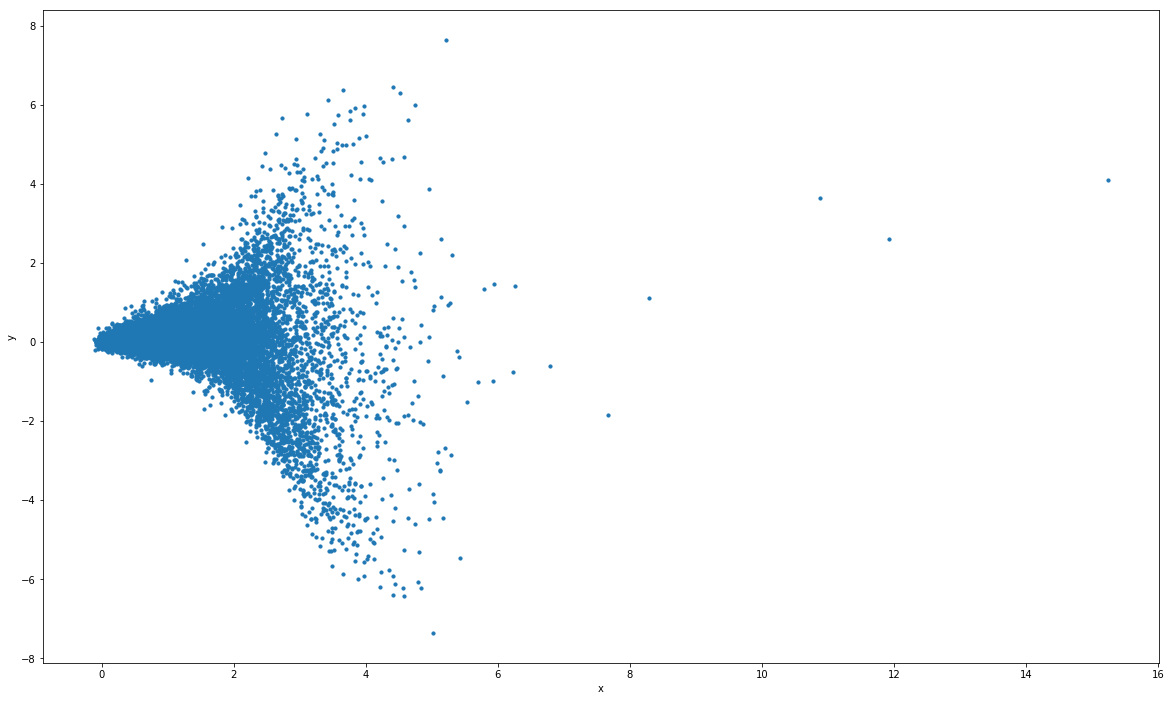

In [24]:
points = pd.DataFrame([(coord[0], coord[1]) for coord in principalComponentsCoOc], columns=["x", "y"])

points.plot.scatter("x", "y", s=10, figsize=(20, 12))

Ejecutamos KMeans para encontrar clusters

In [25]:
clusters = 50
# clusters = 100
# clusters = 200

km_model = KMeans(n_clusters=clusters)
km_model.fit(w2vmatrix)

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:444: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  max_iter=max_iter, verbose=verbose)
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and gu

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:444: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://num

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:444: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  max_iter=max_iter, verbose=verbose)
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and gu

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:444: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  max_iter=max_iter, verbose=verbose)
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and gu

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/damifur/anaconda3/lib/python3.7/site-pac

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=50, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [26]:
c = Counter(sorted(km_model.labels_))
print("\nTotal clusters:",len(c))
for cluster in c:
    print ("Cluster#",cluster," - Total words:",c[cluster])


Total clusters: 50
Cluster# 0  - Total words: 745
Cluster# 1  - Total words: 62
Cluster# 2  - Total words: 5258
Cluster# 3  - Total words: 69
Cluster# 4  - Total words: 33
Cluster# 5  - Total words: 267
Cluster# 6  - Total words: 78
Cluster# 7  - Total words: 52
Cluster# 8  - Total words: 25
Cluster# 9  - Total words: 496
Cluster# 10  - Total words: 1093
Cluster# 11  - Total words: 100
Cluster# 12  - Total words: 268
Cluster# 13  - Total words: 149
Cluster# 14  - Total words: 113
Cluster# 15  - Total words: 119
Cluster# 16  - Total words: 11039
Cluster# 17  - Total words: 100
Cluster# 18  - Total words: 288
Cluster# 19  - Total words: 76
Cluster# 20  - Total words: 49
Cluster# 21  - Total words: 58
Cluster# 22  - Total words: 230
Cluster# 23  - Total words: 194
Cluster# 24  - Total words: 180
Cluster# 25  - Total words: 35
Cluster# 26  - Total words: 1122
Cluster# 27  - Total words: 92
Cluster# 28  - Total words: 129
Cluster# 29  - Total words: 413
Cluster# 30  - Total words: 32
Clust

In [40]:
# Imprimir palabras asociadas a un cluster

# A continuación analizamos distintas clases de equivalencia generadas a partir de clusters para KMeans dividiendo en 50 clusters
num_cluster = 1 # Medios de transporte y cosas relacionadas con viajar, moverse y fenómenos climáticos
# num_cluster = 41 # Cosas ligadas a la ley y el derecho
# num_cluster = 43 # Espectáculo
# num_cluster = 44 # El cluster 44 se corresponde con ciudades y lugares en general
# num_cluster = 45 # El cluster 45 son cosas ligadas a medios de comunicación. También está pampita
# num_cluster = 46 # Esto es futbol y deportes en general
# num_cluster = 47 # Ministerios, sectores del estado, ejes de trabajo de la gestión pública
# num_cluster = 49 # El cluster 49 parecería corresponderse con la clase de equivalencia de palabras que describen relaciones familiares o interpersonales
# num_cluster = 48 # El cluster 48 se corresponde con la clase de noticias e información



for i, word in enumerate(vocabulary):
    if km_model.labels_[i] == num_cluster:
        print(word)

bolsa
recorrido
local
viaje
viajar
grado
lugar
sol
allí
permanecer
puerta
cerrado
abierto
vuelo
aeropuerto
ezeiza
pasajero
operar
registrar
avión
línea
aéreo
entrada
velocidad
alerta
tren
estación
metro
alrededor
subte
ingresar
piso
ruta
intenso
temperatura
altura
habitante
cerca
distancia
circular
cuadras
recorrer
horario
cuadrado
toque
turista
planta
camión
debajo
lluvia
afectado
vía
viento
eléctrico
ráfaga
cielo
nublado
incendio
tormenta
quito
meteorológico
evacuar


In [ ]:
Los datos estan bien representados en el espacio vectorial, los clusters captan distintos sentidos semánticos de las palabras y los agrupan según posibles clases de equivalencia a partir de un criterio semántico.